# Method 6 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

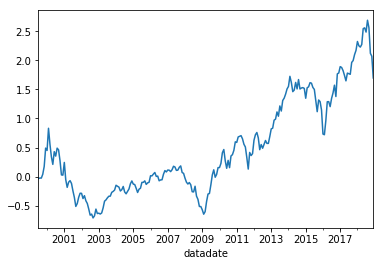

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.489508
2000-12-31   -0.311845
2001-12-31   -0.303783
2002-12-31   -0.489077
2003-12-31    1.109130
2004-12-31    0.202713
2005-12-31   -0.024375
2006-12-31    0.197113
2007-12-31   -0.022819
2008-12-31   -0.540573
2009-12-31    1.380734
2010-12-31    0.383822
2011-12-31   -0.126947
2012-12-31    0.211080
2013-12-31    0.483690
2014-12-31    0.004022
2015-12-31   -0.147677
2016-12-31    0.296622
2017-12-31    0.139860
2018-12-31   -0.149635
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     337.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.43e-95
Time:                        14:44:16   Log-Likelihood:                 430.12
No. Observations:                 234   AIC:                            -850.2
Df Residuals:                     229   BIC:                            -833.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      2.257      0.025       0.001       0.011
mktrf          1.3254      0.073     18.260      0.000       1.182       1.468
me             0.5998      0.084      7.104      0.000       0.433       0.766
ia             0.0204      0.128      0.159      0.874      -0.232       0.273
roe           -1.2157      0.110    -11.067      0.000      -1.432      -0.999
==============================================================================
Omnibus:                      127.420   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1216.208
Skew:                           1.923   Prob(JB):                    8.01e-265
Kurtosis:                      13.486   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     178.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.49e-69
Time:                        14:44:16   Log-Likelihood:                 430.12
No. Observations:                 234   AIC:                            -850.2
Df Residuals:                     229   BIC:                            -833.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      2.133      0.033       0.000       0.011
mktrf          1.3254      0.126     10.492      0.000       1.078       1.573
me             0.5998      0.095      6.324      0.000       0.414       0.786
ia             0.0204      0.168      0.121      0.904      -0.309       0.350
roe           -1.2157      0.190     -6.391      0.000      -1.589      -0.843
==============================================================================
Omnibus:                      127.420   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1216.208
Skew:                           1.923   Prob(JB):                    8.01e-265
Kurtosis:                      13.486   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     207.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.55e-75
Time:                        14:44:16   Log-Likelihood:                 430.12
No. Observations:                 234   AIC:                            -850.2
Df Residuals:                     229   BIC:                            -833.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      2.032      0.042       0.000       0.012
mktrf          1.3254      0.124     10.660      0.000       1.082       1.569
me             0.5998      0.106      5.652      0.000       0.392       0.808
ia             0.0204      0.146      0.140      0.889      -0.265       0.306
roe           -1.2157      0.202     -6.032      0.000      -1.611      -0.821
==============================================================================
Omnibus:                      127.420   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1216.208
Skew:                           1.923   Prob(JB):                    8.01e-265
Kurtosis:                      13.486   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     228.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.46e-87
Time:                        14:44:16   Log-Likelihood:                 414.23
No. Observations:                 234   AIC:                            -816.5
Df Residuals:                     228   BIC:                            -795.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.003      1.726      0.086      -0.001       0.011
mktrf          1.4562      0.078     18.666      0.000       1.302       1.610
smb            0.6150      0.103      5.975      0.000       0.412       0.818
hml            0.2009      0.121      1.655      0.099      -0.038       0.440
rmw           -1.0963      0.137     -7.988      0.000      -1.367      -0.826
cma            0.0495      0.174      0.284      0.777      -0.294       0.393
==============================================================================
Omnibus:                      133.518   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              984.683
Skew:                           2.162   Prob(JB):                    1.51e-214
Kurtosis:                      12.072   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     140.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.40e-67
Time:                        14:44:16   Log-Likelihood:                 414.23
No. Observations:                 234   AIC:                            -816.5
Df Residuals:                     228   BIC:                            -795.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.003      1.668      0.095      -0.001       0.011
mktrf          1.4562      0.096     15.226      0.000       1.269       1.644
smb            0.6150      0.108      5.717      0.000       0.404       0.826
hml            0.2009      0.164      1.226      0.220      -0.120       0.522
rmw           -1.0963      0.197     -5.565      0.000      -1.482      -0.710
cma            0.0495      0.246      0.202      0.840      -0.432       0.531
==============================================================================
Omnibus:                      133.518   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              984.683
Skew:                           2.162   Prob(JB):                    1.51e-214
Kurtosis:                      12.072   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     179.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.07e-77
Time:                        14:44:16   Log-Likelihood:                 414.23
No. Observations:                 234   AIC:                            -816.5
Df Residuals:                     228   BIC:                            -795.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.003      1.530      0.126      -0.001       0.011
mktrf          1.4562      0.083     17.608      0.000       1.294       1.618
smb            0.6150      0.114      5.386      0.000       0.391       0.839
hml            0.2009      0.121      1.662      0.096      -0.036       0.438
rmw           -1.0963      0.209     -5.252      0.000      -1.505      -0.687
cma            0.0495      0.213      0.232      0.816      -0.368       0.467
==============================================================================
Omnibus:                      133.518   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              984.683
Skew:                           2.162   Prob(JB):                    1.51e-214
Kurtosis:                      12.072   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     274.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.52e-86
Time:                        14:44:16   Log-Likelihood:                 409.92
No. Observations:                 234   AIC:                            -809.8
Df Residuals:                     229   BIC:                            -792.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.672      0.502      -0.004       0.007
mktrf          1.5263      0.073     20.949      0.000       1.383       1.670
smb            1.1182      0.091     12.295      0.000       0.939       1.297
hml           -0.0576      0.090     -0.638      0.524      -0.236       0.120
umd           -0.4251      0.059     -7.172      0.000      -0.542      -0.308
==============================================================================
Omnibus:                       93.411   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.133
Skew:                           1.493   Prob(JB):                    2.25e-107
Kurtosis:                       9.438   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     84.98
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.87e-44
Time:                        14:44:16   Log-Likelihood:                 409.92
No. Observations:                 234   AIC:                            -809.8
Df Residuals:                     229   BIC:                            -792.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.691      0.490      -0.003       0.007
mktrf          1.5263      0.111     13.701      0.000       1.308       1.745
smb            1.1182      0.118      9.463      0.000       0.887       1.350
hml           -0.0576      0.115     -0.499      0.618      -0.284       0.169
umd           -0.4251      0.112     -3.798      0.000      -0.645      -0.206
==============================================================================
Omnibus:                       93.411   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.133
Skew:                           1.493   Prob(JB):                    2.25e-107
Kurtosis:                       9.438   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     92.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.06e-47
Time:                        14:44:16   Log-Likelihood:                 409.92
No. Observations:                 234   AIC:                            -809.8
Df Residuals:                     229   BIC:                            -792.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.689      0.491      -0.004       0.007
mktrf          1.5263      0.109     13.960      0.000       1.312       1.741
smb            1.1182      0.112      9.959      0.000       0.898       1.338
hml           -0.0576      0.103     -0.561      0.575      -0.259       0.144
umd           -0.4251      0.114     -3.736      0.000      -0.648      -0.202
==============================================================================
Omnibus:                       93.411   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.133
Skew:                           1.493   Prob(JB):                    2.25e-107
Kurtosis:                       9.438   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     156.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-45
Time:                        14:44:16   Log-Likelihood:                 196.71
No. Observations:                 120   AIC:                            -383.4
Df Residuals:                     115   BIC:                            -369.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.005      2.086      0.039       0.000       0.019
mktrf          1.2597      0.124     10.185      0.000       1.015       1.505
me             0.5243      0.122      4.292      0.000       0.282       0.766
ia            -0.0489      0.191     -0.256      0.799      -0.428       0.330
roe           -1.2812      0.169     -7.568      0.000      -1.617      -0.946
==============================================================================
Omnibus:                       57.541   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.020
Skew:                           1.595   Prob(JB):                     4.66e-58
Kurtosis:                       9.529   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     138.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.83e-43
Time:                        14:44:16   Log-Likelihood:                 196.71
No. Observations:                 120   AIC:                            -383.4
Df Residuals:                     115   BIC:                            -369.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.004      2.279      0.023       0.001       0.018
mktrf          1.2597      0.195      6.459      0.000       0.877       1.642
me             0.5243      0.128      4.112      0.000       0.274       0.774
ia            -0.0489      0.234     -0.209      0.834      -0.507       0.410
roe           -1.2812      0.248     -5.159      0.000      -1.768      -0.794
==============================================================================
Omnibus:                       57.541   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.020
Skew:                           1.595   Prob(JB):                     4.66e-58
Kurtosis:                       9.529   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     170.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.56e-47
Time:                        14:44:16   Log-Likelihood:                 196.71
No. Observations:                 120   AIC:                            -383.4
Df Residuals:                     115   BIC:                            -369.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.004      2.333      0.020       0.002       0.018
mktrf          1.2597      0.193      6.524      0.000       0.881       1.638
me             0.5243      0.139      3.776      0.000       0.252       0.796
ia            -0.0489      0.199     -0.245      0.806      -0.440       0.342
roe           -1.2812      0.272     -4.708      0.000      -1.815      -0.748
==============================================================================
Omnibus:                       57.541   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.020
Skew:                           1.595   Prob(JB):                     4.66e-58
Kurtosis:                       9.529   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     107.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-41
Time:                        14:44:16   Log-Likelihood:                 189.29
No. Observations:                 120   AIC:                            -366.6
Df Residuals:                     114   BIC:                            -349.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0103      0.005      2.048      0.043       0.000       0.020
mktrf          1.5182      0.139     10.896      0.000       1.242       1.794
smb            0.5590      0.158      3.542      0.001       0.246       0.872
hml            0.0831      0.193      0.430      0.668      -0.300       0.466
rmw           -1.0330      0.228     -4.530      0.000      -1.485      -0.581
cma            0.0998      0.250      0.400      0.690      -0.395       0.595
==============================================================================
Omnibus:                       71.215   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.539
Skew:                           2.104   Prob(JB):                     4.10e-70
Kurtosis:                       9.797   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     99.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.56e-40
Time:                        14:44:16   Log-Likelihood:                 189.29
No. Observations:                 120   AIC:                            -366.6
Df Residuals:                     114   BIC:                            -349.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0103      0.004      2.406      0.016       0.002       0.019
mktrf          1.5182      0.173      8.758      0.000       1.178       1.858
smb            0.5590      0.159      3.509      0.000       0.247       0.871
hml            0.0831      0.166      0.501      0.617      -0.242       0.408
rmw           -1.0330      0.278     -3.713      0.000      -1.578      -0.488
cma            0.0998      0.280      0.357      0.721      -0.448       0.648
==============================================================================
Omnibus:                       71.215   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.539
Skew:                           2.104   Prob(JB):                     4.10e-70
Kurtosis:                       9.797   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     120.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.65e-44
Time:                        14:44:16   Log-Likelihood:                 189.29
No. Observations:                 120   AIC:                            -366.6
Df Residuals:                     114   BIC:                            -349.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0103      0.004      2.367      0.018       0.002       0.019
mktrf          1.5182      0.140     10.880      0.000       1.245       1.792
smb            0.5590      0.162      3.441      0.001       0.241       0.877
hml            0.0831      0.143      0.581      0.562      -0.197       0.363
rmw           -1.0330      0.299     -3.454      0.001      -1.619      -0.447
cma            0.0998      0.234      0.427      0.669      -0.358       0.558
==============================================================================
Omnibus:                       71.215   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.539
Skew:                           2.104   Prob(JB):                     4.10e-70
Kurtosis:                       9.797   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     138.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.75e-43
Time:                        14:44:16   Log-Likelihood:                 190.38
No. Observations:                 120   AIC:                            -370.8
Df Residuals:                     115   BIC:                            -356.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.005      1.229      0.221      -0.004       0.015
mktrf          1.5856      0.115     13.805      0.000       1.358       1.813
smb            1.0926      0.131      8.355      0.000       0.834       1.352
hml           -0.1807      0.131     -1.379      0.170      -0.440       0.079
umd           -0.4048      0.081     -5.013      0.000      -0.565      -0.245
==============================================================================
Omnibus:                       49.835   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.491
Skew:                           1.428   Prob(JB):                     5.26e-41
Kurtosis:                       8.380   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     53.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-25
Time:                        14:44:16   Log-Likelihood:                 190.38
No. Observations:                 120   AIC:                            -370.8
Df Residuals:                     115   BIC:                            -356.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.004      1.446      0.148      -0.002       0.014
mktrf          1.5856      0.177      8.953      0.000       1.238       1.933
smb            1.0926      0.134      8.130      0.000       0.829       1.356
hml           -0.1807      0.143     -1.260      0.208      -0.462       0.100
umd           -0.4048      0.120     -3.384      0.001      -0.639      -0.170
==============================================================================
Omnibus:                       49.835   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.491
Skew:                           1.428   Prob(JB):                     5.26e-41
Kurtosis:                       8.380   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     62.15
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.24e-28
Time:                        14:44:16   Log-Likelihood:                 190.38
No. Observations:                 120   AIC:                            -370.8
Df Residuals:                     115   BIC:                            -356.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.004      1.544      0.123      -0.002       0.013
mktrf          1.5856      0.178      8.930      0.000       1.238       1.934
smb            1.0926      0.123      8.915      0.000       0.852       1.333
hml           -0.1807      0.133     -1.359      0.174      -0.441       0.080
umd           -0.4048      0.122     -3.306      0.001      -0.645      -0.165
==============================================================================
Omnibus:                       49.835   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.491
Skew:                           1.428   Prob(JB):                     5.26e-41
Kurtosis:                       8.380   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     213.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-50
Time:                        14:44:16   Log-Likelihood:                 254.65
No. Observations:                 114   AIC:                            -499.3
Df Residuals:                     109   BIC:                            -485.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.901      0.370      -0.003       0.008
mktrf          1.3832      0.078     17.747      0.000       1.229       1.538
me             0.7264      0.120      6.037      0.000       0.488       0.965
ia             0.1234      0.167      0.739      0.461      -0.207       0.454
roe           -1.1399      0.147     -7.772      0.000      -1.431      -0.849
==============================================================================
Omnibus:                       26.919   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.065
Skew:                           0.986   Prob(JB):                     8.15e-12
Kurtosis:                       5.619   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     133.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.15e-41
Time:                        14:44:16   Log-Likelihood:                 254.65
No. Observations:                 114   AIC:                            -499.3
Df Residuals:                     109   BIC:                            -485.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.069      0.285      -0.002       0.007
mktrf          1.3832      0.098     14.050      0.000       1.190       1.576
me             0.7264      0.138      5.263      0.000       0.456       0.997
ia             0.1234      0.177      0.695      0.487      -0.224       0.471
roe           -1.1399      0.228     -4.994      0.000      -1.587      -0.693
==============================================================================
Omnibus:                       26.919   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.065
Skew:                           0.986   Prob(JB):                     8.15e-12
Kurtosis:                       5.619   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     155.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.50e-44
Time:                        14:44:16   Log-Likelihood:                 254.65
No. Observations:                 114   AIC:                            -499.3
Df Residuals:                     109   BIC:                            -485.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.134      0.257      -0.002       0.006
mktrf          1.3832      0.095     14.605      0.000       1.198       1.569
me             0.7264      0.163      4.469      0.000       0.408       1.045
ia             0.1234      0.178      0.691      0.489      -0.226       0.473
roe           -1.1399      0.221     -5.148      0.000      -1.574      -0.706
==============================================================================
Omnibus:                       26.919   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.065
Skew:                           0.986   Prob(JB):                     8.15e-12
Kurtosis:                       5.619   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     144.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.64e-46
Time:                        14:44:16   Log-Likelihood:                 246.71
No. Observations:                 114   AIC:                            -481.4
Df Residuals:                     108   BIC:                            -465.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.003      0.072      0.942      -0.005       0.006
mktrf          1.4247      0.080     17.796      0.000       1.266       1.583
smb            0.6889      0.130      5.301      0.000       0.431       0.947
hml            0.3805      0.166      2.296      0.024       0.052       0.709
rmw           -1.0609      0.203     -5.227      0.000      -1.463      -0.659
cma           -0.0428      0.258     -0.166      0.868      -0.554       0.468
==============================================================================
Omnibus:                       12.282   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.129
Skew:                           0.575   Prob(JB):                     0.000314
Kurtosis:                       4.439   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     111.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.97e-41
Time:                        14:44:16   Log-Likelihood:                 246.71
No. Observations:                 114   AIC:                            -481.4
Df Residuals:                     108   BIC:                            -465.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.003      0.068      0.946      -0.006       0.006
mktrf          1.4247      0.078     18.359      0.000       1.273       1.577
smb            0.6889      0.131      5.264      0.000       0.432       0.945
hml            0.3805      0.177      2.144      0.032       0.033       0.728
rmw           -1.0609      0.227     -4.682      0.000      -1.505      -0.617
cma           -0.0428      0.214     -0.200      0.841      -0.462       0.376
==============================================================================
Omnibus:                       12.282   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.129
Skew:                           0.575   Prob(JB):                     0.000314
Kurtosis:                       4.439   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     128.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.02e-44
Time:                        14:44:16   Log-Likelihood:                 246.71
No. Observations:                 114   AIC:                            -481.4
Df Residuals:                     108   BIC:                            -465.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.003      0.069      0.945      -0.006       0.006
mktrf          1.4247      0.077     18.500      0.000       1.274       1.576
smb            0.6889      0.145      4.746      0.000       0.404       0.973
hml            0.3805      0.151      2.527      0.011       0.085       0.676
rmw           -1.0609      0.188     -5.651      0.000      -1.429      -0.693
cma           -0.0428      0.218     -0.197      0.844      -0.469       0.384
==============================================================================
Omnibus:                       12.282   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.129
Skew:                           0.575   Prob(JB):                     0.000314
Kurtosis:                       4.439   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     157.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-44
Time:                        14:44:16   Log-Likelihood:                 239.36
No. Observations:                 114   AIC:                            -468.7
Df Residuals:                     109   BIC:                            -455.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.203      0.839      -0.007       0.005
mktrf          1.4578      0.084     17.262      0.000       1.290       1.625
smb            0.9393      0.132      7.133      0.000       0.678       1.200
hml            0.3677      0.136      2.712      0.008       0.099       0.637
umd           -0.3693      0.102     -3.610      0.000      -0.572      -0.167
==============================================================================
Omnibus:                       17.406   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.725
Skew:                           0.703   Prob(JB):                     9.54e-07
Kurtosis:                       4.965   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     192.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-48
Time:                        14:44:16   Log-Likelihood:                 239.36
No. Observations:                 114   AIC:                            -468.7
Df Residuals:                     109   BIC:                            -455.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.247      0.805      -0.005       0.004
mktrf          1.4578      0.084     17.323      0.000       1.293       1.623
smb            0.9393      0.138      6.820      0.000       0.669       1.209
hml            0.3677      0.180      2.040      0.041       0.014       0.721
umd           -0.3693      0.119     -3.103      0.002      -0.603      -0.136
==============================================================================
Omnibus:                       17.406   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.725
Skew:                           0.703   Prob(JB):                     9.54e-07
Kurtosis:                       4.965   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     302.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.30e-58
Time:                        14:44:16   Log-Likelihood:                 239.36
No. Observations:                 114   AIC:                            -468.7
Df Residuals:                     109   BIC:                            -455.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.253      0.800      -0.005       0.004
mktrf          1.4578      0.080     18.131      0.000       1.300       1.615
smb            0.9393      0.127      7.420      0.000       0.691       1.187
hml            0.3677      0.178      2.066      0.039       0.019       0.717
umd           -0.3693      0.117     -3.160      0.002      -0.598      -0.140
==============================================================================
Omnibus:                       17.406   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.725
Skew:                           0.703   Prob(JB):                     9.54e-07
Kurtosis:                       4.965   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""